# Task 1.1 - Modal → Amodal Mask Prediction Baseline

In [8]:
!tar -xvzf "ff5da6d6ecae486bb294aeaf5ee8f8a1 (3).tar.gz" -C /content

tar: Error opening archive: Failed to open 'ff5da6d6ecae486bb294aeaf5ee8f8a1 (3).tar.gz'


In [29]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pprint import pprint

# Dataset class with safe pair matching
class RGBAtoSegmentationDataset(Dataset):
    def __init__(self, root_path):
        self.obj_paths = [f for f in root_path.rglob("obj_*")]

        assert len(self.obj_paths) > 0, "No matched obj paths found."

        self.transform_img = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.transform_mask = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.obj_paths)

    def __getitem__(self, idx):
        # self.rgb_paths = []
        # self.seg_paths = []
        
        obj = self.obj_paths[idx]

        self.rgb_path = obj.parent / "rgba_00012.png"
        self.obj_amod_seg_file = obj / "segmentation_00012.png"
        self.seg_path = obj.parent / "segmentation_00012.png"

        rgba = Image.open(self.rgb_path).convert("RGB")
        amod = Image.open(self.obj_amod_seg_file).convert("L")


        seg_np = np.array(Image.open(self.seg_path))
        seg_mask = (seg_np == 12).astype(np.uint8)  # binary mask with 0 and 1
        seg_img = Image.fromarray(seg_mask * 255)  # for compatibility with resizing

        rgba = self.transform_img(rgba)
        seg = self.transform_img(seg_img)

        input = torch.cat([rgba, seg], dim=0)
        output = torch.from_numpy(np.array(self.transform_mask(amod))).long()
        output = (output > 0).long()

        #print(output.max())
        # print("Input shape:", input.shape)
        # print("Output shape:", output.shape)

        return input, output


In [ ]:
# U-Net
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = nn.Sequential(CBR(in_channels, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.pool = nn.MaxPool2d(2)
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = nn.Sequential(CBR(256, 128), CBR(128, 128))
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(CBR(128, 64), CBR(64, 64))
        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d1 = self.up1(e3)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        return self.out(d2)


In [60]:
# IoU
def compute_iou(pred_mask, true_mask):
    pred_mask = torch.argmax(pred_mask, dim=1)
    intersection = ((pred_mask == true_mask) & (true_mask > 0)).sum().float()
    union = ((pred_mask > 0) | (true_mask > 0)).sum().float()
    return (intersection + 1e-6) / (union + 1e-6)

# Training
def train_model(model, dataloader, device, epochs=5):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        total_iou = 0.0
        for img, mask in tqdm(dataloader):
            # print(img.shape)  # expect [batch_size, 4, 256, 256]
            # print(mask.shape) # expect [batch_size, 256, 256]
            # print(mask.min(), mask.max())  # should be 0 and 1
            img, mask = img.to(device), mask.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_iou += compute_iou(out, mask).item()
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(dataloader):.4f}, IoU = {total_iou/len(dataloader):.4f}")

# Evaluation
def evaluate_model(model, dataloader, device):
    model.eval()
    total_iou = 0.0
    with torch.no_grad():
        for img, mask in tqdm(dataloader):
            img, mask = img.to(device), mask.to(device)
            out = model(img)
            total_iou += compute_iou(out, mask).item()
    print(f"Test IoU = {total_iou / len(dataloader):.4f}")

# Optional: Visualize sample prediction
def visualize_prediction(model, dataset, device, idx=0):
    model.eval()
    img, true_mask = dataset[idx]

    # Split input: RGB only for display
    rgb_img = img[:3, :, :].permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img * 255).astype(np.uint8)

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).squeeze()
        print(pred.shape)
        # Assume binary segmentation; threshold sigmoid output
        print(pred.max())
        pred_mask = (torch.softmax(pred, dim=0)[1] > 0.5).cpu().numpy().astype(np.uint8)
        print(pred_mask.max())
        print(pred_mask.min())

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(rgb_img)
    axs[0].set_title("Input Image (RGB)")

    axs[1].imshow(true_mask, cmap="gray")
    axs[1].set_title("True Mask")

    axs[2].imshow(pred_mask, cmap="gray")
    axs[2].set_title("Predicted Mask")

    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()



torch.Size([2, 256, 256])
6.8869500160217285
None
0
0


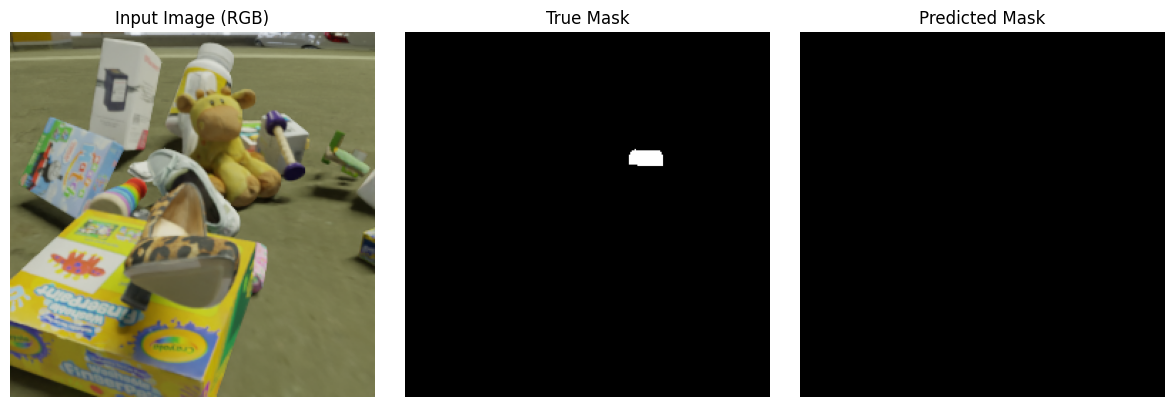

In [59]:
visualize_prediction(model, test_set, device, idx=0)

In [4]:
root_path = Path(fr"content")
dataset = RGBAtoSegmentationDataset(root_path)
dataset[0]  # Example to trigger dataset loading and item retrieval

tensor(1)


(tensor([[[0.4824, 0.5373, 0.5529,  ..., 0.4353, 0.4392, 0.4784],
          [0.5333, 0.5490, 0.5882,  ..., 0.3804, 0.3961, 0.4353],
          [0.5608, 0.5569, 0.5569,  ..., 0.3765, 0.3922, 0.4275],
          ...,
          [0.5961, 0.5412, 0.4588,  ..., 0.6353, 0.6392, 0.6431],
          [0.5725, 0.5255, 0.4431,  ..., 0.6314, 0.6431, 0.6353],
          [0.5451, 0.5137, 0.4392,  ..., 0.6196, 0.6471, 0.6275]],
 
         [[0.4863, 0.5490, 0.5765,  ..., 0.4431, 0.4549, 0.5098],
          [0.5765, 0.5882, 0.6392,  ..., 0.4157, 0.4314, 0.4824],
          [0.6275, 0.6157, 0.6118,  ..., 0.4235, 0.4392, 0.4863],
          ...,
          [0.6824, 0.6235, 0.5216,  ..., 0.6353, 0.6353, 0.6510],
          [0.6588, 0.6000, 0.4980,  ..., 0.6275, 0.6314, 0.6431],
          [0.6235, 0.5882, 0.4980,  ..., 0.6314, 0.6588, 0.6510]],
 
         [[0.4353, 0.4902, 0.5137,  ..., 0.3765, 0.3843, 0.4510],
          [0.4706, 0.5020, 0.5686,  ..., 0.3569, 0.3608, 0.3922],
          [0.4784, 0.4824, 0.5059,  ...,

Train size: 177, Test size: 45


100%|██████████| 45/45 [00:03<00:00, 12.36it/s]


Epoch 1: Loss = 0.2570, IoU = 0.0085


100%|██████████| 45/45 [00:03<00:00, 13.50it/s]


Epoch 2: Loss = 0.1102, IoU = 0.0008


100%|██████████| 45/45 [00:03<00:00, 13.55it/s]


Epoch 3: Loss = 0.0980, IoU = 0.0005


100%|██████████| 45/45 [00:03<00:00, 13.77it/s]


Epoch 4: Loss = 0.0981, IoU = 0.0000


100%|██████████| 45/45 [00:03<00:00, 13.78it/s]


Epoch 5: Loss = 0.0968, IoU = 0.0000


100%|██████████| 12/12 [00:00<00:00, 33.71it/s]


Test IoU = 0.0000


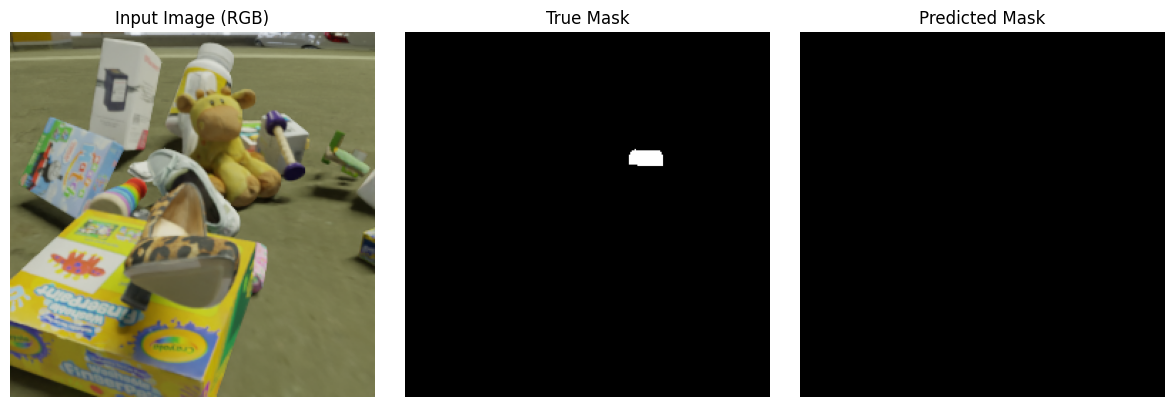

In [36]:
# Main script
root_path = Path(fr"content")
dataset = RGBAtoSegmentationDataset(root_path)

# Split into train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

print(f"Train size: {len(train_set)}, Test size: {len(test_set)}")

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=4, out_channels=2).to(device)

# Train and evaluate
train_model(model, train_loader, device, epochs=5)
evaluate_model(model, test_loader, device)

# Visualize prediction from test set
visualize_prediction(model, test_set, device, idx=0)

In [19]:
from pathlib import Path
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# ——— Transforms ————————————————
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
transform_mask = transforms.Resize((256, 256))
# ——— Make sure 'model' is already defined & trained above ———
# If you restarted the runtime, re-define the UNet class and then:
# model = UNet().to(device)
# model.load_state_dict(torch.load("model.pth"))
# model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()
# ——— Data root & find object folders —————————
root_path   = Path("/content/ff5da6d6ecae486bb294aeaf5ee8f8a1")
obj_folders = sorted(root_path.rglob("obj_*"))
print(f"Found {len(obj_folders)} object folders.")
# ——— Inference loop ——————————————————————
for obj_path in tqdm(obj_folders, desc="Infer middle frames"):
    rgba_files = sorted(obj_path.glob("rgba_*.png"))
    amodal_seg_files  = sorted(obj_path.glob("segmentation_*.png"))
    if not rgba_files or not amodal_seg_files:
        continue
    mid = len(rgba_files) // 2
    img = Image.open(rgba_files[mid]).convert("RGB")
    gt  = Image.open(amodal_seg_files[mid]).convert("L")
    # preprocess
    x = transform_img(img).unsqueeze(0).to(device)
    g = torch.from_numpy(np.array(transform_mask(gt))).long()
    g[g > 0] = 1
    # predict
    with torch.no_grad():
        out      = model(x)                     # (1, 2, H, W)
        pred_np  = torch.argmax(out, dim=1)[0]  # (H, W), values 0 or 1
        pred_np  = pred_np.cpu().numpy()
    # plot
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(img);     plt.title("Input");      plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(g, cmap="gray"); plt.title("Ground Truth"); plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(pred_np, cmap="gray"); plt.title("Prediction"); plt.axis("off")
    plt.tight_layout()
    plt.show()


Found 0 object folders.


Infer middle frames: 0it [00:00, ?it/s]
